In [1]:
# Python packages and utilities
import os
from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML

import mlxtend

#RDKit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs


# scikit-learn

import sklearn
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler # This is sklearns auto-scaling function
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, ConstantKernel as C
from sklearn.feature_selection import RFECV, RFE
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
import pickle
from pickle import dump
import smogn

#imbalenced learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
except ModuleNotFoundError:
    !pip install -U imbalanced-learn
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN

try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_pca_correlation_graph
# scikitplot library

import scikitplot as skplt

# !pip install pip install -U imbalanced-learn

# own module
from pythia import classification_metrics as cmetrics
from pythia import fingerprints_generation as fp
from pythia import molecules_and_structures as mo
from pythia import plots as pltsk
from pythia import workflow_functions as cwf

# utility
%load_ext autoreload
%autoreload 2
%aimport
import importlib


import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)


random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)

In [3]:
data = pd.read_csv("DFTdata.csv",header=None)

In [4]:
data

,0,1,2,3,4,...,38,39,40,41,42
0,-5.79,-1.47,-0.148,1.79,5.17,...,2.74,11.57,3.84,2.72,11.50
1,-5.83,-2.40,-0.149,1.82,6.86,...,2.74,11.57,3.84,2.72,11.50
2,-5.79,-1.47,-0.148,1.79,5.17,...,4.28,9.79,9.09,3.03,7.92
3,-5.83,-2.40,-0.149,1.82,6.86,...,4.28,9.79,9.09,3.03,7.92
4,-5.79,-1.47,-0.148,1.79,5.17,...,4.45,9.75,8.83,3.12,8.31
...,...,...,...,...,...,...,...,...,...,...,...
114,-5.57,-2.16,-0.166,2.08,6.56,...,2.74,11.57,3.84,2.72,11.50
115,-5.79,-1.47,-0.148,1.79,5.17,...,1.35,12.11,2.49,1.55,11.53
116,-5.83,-2.40,-0.149,1.82,6.86,...,1.35,12.11,2.49,1.55,11.53
117,-5.57,-2.17,-0.159,2.31,6.56,...,1.35,12.11,2.49,1.55,11.53


In [5]:
ddg = pd.read_csv("DDG.csv",header=None)

In [6]:
ddg = ddg[0]

In [7]:
X = data
y = ddg # is not used

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X)

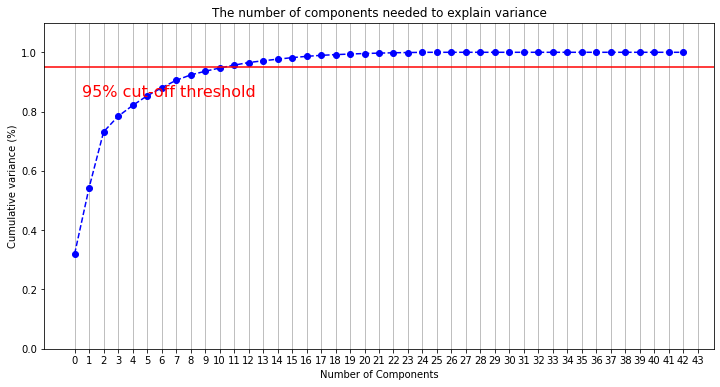

In [8]:
pca = PCA().fit(data_rescaled)
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(0, 43, step=1) # change 44 according to number of features!!!
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 44, step=1)) #change here as well
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

The important descriptors are 12 according to the plot above

In [9]:
model = PCA(n_components = 0.95, whiten=True).fit(data_rescaled)
X_pc = model.transform(data_rescaled)

n_pcs= model.components_.shape[0]
print(n_pcs)

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

# if your features have names, as they should, you can do the following. if not no need to remove from comments
# Name all ffeatures in order as they appear in your csv eg.
# initial_feature_names = ['HOMOsub', 'LUMOsub', 'C1', 'N1', 'Cindole', 'Dipolesub', 'L(N-C1)',
#        'B1(N-C1)', 'B5(N-C1)', 'L(N-C3)', 'B1(N-C3)', 'B5(N-C3)', 'L(N-C12)',
#        'B5(H-Cind+A2ole)', 'B5(N-C12)', 'L(H-Cindole)', 'B1(H-Cindole)',
#        'B5(H-Cindole)', 'HOMO', 'LUMO', 'TOTAL NH', 'TOTAL CN', 'TOTAL N49-H',
#        'Cl- Charge', 'TOTAL Hcharge', 'AVG H CHRG', 'DIPOLE', '49Cl NMR']
# get the names
# most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
# print(most_important_names)

# using LIST COMPREHENSION HERE AGAIN
# dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# If no names are included continue here
dic = {'PC{}'.format(i+1): most_important[i] for i in range(n_pcs)}
# build the dataframe
df = pd.DataFrame(dic.items())
df


12


,0,1
0,PC1,12
1,PC2,30
2,PC3,10
3,PC4,25
4,PC5,32
5,PC6,7
6,PC7,22
7,PC8,36
8,PC9,32
9,PC10,7


In [10]:
df[1]

0     12
1     30
2     10
3     25
4     32
5      7
6     22
7     36
8     32
9      7
10     0
11    24
Name: 1, dtype: int64

make dataframe only containing the PCA features

In [11]:
col_names = [col for col in data.columns if col in df[1].values and data[col].all()]

In [12]:
col_names

[0, 7, 10, 12, 22, 24, 25, 32, 36]

In [13]:
data = data[col_names]
print(data)

       0     7     10    12    22    24    25    32    36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
1   -5.83  6.50 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
2   -5.79  6.53 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
3   -5.83  6.56 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
4   -5.79  6.59 -4.55  1.21  7.51  8.45  7.03  2.73  9.14
..    ...   ...   ...   ...   ...   ...   ...   ...   ...
114 -5.57  4.62 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
115 -5.79  6.47 -3.62  1.68  7.71  6.01  4.90  2.67  9.69
116 -5.83  6.50 -3.62  1.68  7.71  6.01  4.90  2.67  9.69
117 -5.57  6.57 -3.62  1.68  7.71  6.01  4.90  2.67  9.69
118 -5.57  4.62 -3.62  1.68  7.71  6.01  4.90  2.67  9.69

[119 rows x 9 columns]


In [14]:
# Possible source:    https://www.kaggle.com/ankitjha/comparing-regression-models
kfold_reg_names = ["LassoCV","KNeighborsRegressor", "DecisionTreeRegressor", 
                   "BayesianRegr", "GaussianProcessRegressor"]
kfold_regressors = [
    LassoCV(random_state=random_seed, cv=10,selection='random',normalize=True,max_iter=1000000),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=random_seed),
#     svm.SVR(),
    linear_model.BayesianRidge(n_iter=100000,normalize=True),
    GaussianProcessRegressor()]

kernel = DotProduct() + WhiteKernel()
kfold_regressors_parameters = {
    "LassoCV":{},
    "KNeighborsRegressor": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "DecisionTreeRegressor": {"max_depth": [2, 3, 4, 5, 7, 10]},
#     "SVR": {"kernel":['linear', 'poly', 'rbf'], "degree":[2,3], "gamma":['auto','scale'], "coef0":[0,1], 'C':[100]},    
    "BayesianRegr":{'alpha_1':[1e-06, 10], 'alpha_2': [1e-06,10],'lambda_1':[1e-06,10], 'lambda_2': [1e-06,10]},
    "GaussianProcessRegressor": {},  
}

In [15]:
%%capture
cwf.kfold_test_regressor_with_optimization(data,ddg, kfold_regressors, kfold_regressors_parameters, scale=False, cv=5, n_repeats=10, rgs_names=kfold_reg_names)

Features: Int64Index([0, 7, 10, 12, 22, 24, 25, 32, 36], dtype='int64')
Starting regression

-----
Begin LassoCV
-----

Directory LassoCV already exists will be overwritten
----- LassoCV: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	Best parameters; {}
	-6.8177 (+/-9.2031) for {}

	----- Predicting using: LassoCV -----
	Xtrain:        0     7     10    12    22    24    25    32     36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59   9.33
2   -5.79  6.53 -4.55  1.2

[7, 22, 31, 51, 66, 69, 72, 78, 88, 101, 106, 111]
	Train indx [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  67  68  70  71  73  74  75  76  77  79
  80  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98
  99 100 102 103 104 105 107 108 109 110 112 113 114 115 116 117 118]
	Test indx: [  7  22  31  51  66  69  72  78  88 101 106 111]
	Best parameters; {}
	-3.0761 (+/-3.1121) for {}

	----- Predicting using: LassoCV -----
	Xtrain:        0     7     10    12    22    24    25    32    36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
1   -5.83  6.50 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
2   -5.79  6.53 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
3   -5.83  6.56 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
4   -5.79  6.59 -4.55  1.21  7.51  8.45  7.03  2.73 

	Best parameters; {}
	-6.9514 (+/-7.4616) for {}

	----- Predicting using: LassoCV -----
	Xtrain:        0     7     10    12    22    24    25    32    36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
1   -5.83  6.50 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
2   -5.79  6.53 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
3   -5.83  6.56 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
4   -5.79  6.59 -4.55  1.21  7.51  8.45  7.03  2.73  9.14
..    ...   ...   ...   ...   ...   ...   ...   ...   ...
113 -5.57  6.57 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
114 -5.57  4.62 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
116 -5.83  6.50 -3.62  1.68  7.71  6.01  4.90  2.67  9.69
117 -5.57  6.57 -3.62  1.68  7.71  6.01  4.90  2.67  9.69
118 -5.57  4.62 -3.62  1.68  7.71  6.01  4.90  2.67  9.69

[107 rows x 9 columns]
	Xtest:        0     7     10    12    22     24    25    32     36
14  -5.41  6.49 -4.58  1.19  7.52   8.10  7.21  3.04   9.12
19  -5.95  6.47 -4.58  1.19  7.52   8.10  7.21  3.04  


	score (LassoCV): 0.04988078190479606
The average scores are: 1.7576137714310582, and the std scores are: 0.3221107717757

-----
Begin KNeighborsRegressor
-----

----- KNeighborsRegressor: Fold 0 -----
[1, 3, 9, 25, 26, 36, 47, 52, 65, 99, 107, 114]
	Train indx [  0   2   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  27  28  29  30  31  32  33  34  35  37  38  39  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
 100 101 102 103 104 105 106 108 109 110 111 112 113 115 116 117 118]
	Test indx: [  1   3   9  25  26  36  47  52  65  99 107 114]
	Best parameters; {'n_neighbors': 3}
	-0.8746 (+/-1.0499) for {'n_neighbors': 2}
	-0.8402 (+/-1.0705) for {'n_neighbors': 3}
	-0.9063 (+/-1.1008) for {'n_neighbors': 4}
	-0.8746 (+/-1.0615) for {'n_neighbors': 5}
	-0.9927 (+/-1.0751) for {'


	score (KNeighborsRegressor): 0.4068168953710135
----- KNeighborsRegressor: Fold 3 -----
[7, 22, 31, 51, 66, 69, 72, 78, 88, 101, 106, 111]
	Train indx [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  67  68  70  71  73  74  75  76  77  79
  80  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98
  99 100 102 103 104 105 107 108 109 110 112 113 114 115 116 117 118]
	Test indx: [  7  22  31  51  66  69  72  78  88 101 106 111]
	Best parameters; {'n_neighbors': 2}
	-0.0285 (+/-0.2015) for {'n_neighbors': 2}
	-0.1128 (+/-0.4040) for {'n_neighbors': 3}
	-0.3841 (+/-0.6275) for {'n_neighbors': 4}
	-0.5206 (+/-0.7869) for {'n_neighbors': 5}
	-0.6466 (+/-0.7719) for {'n_neighbors': 6}
	-0.7688 (+/-0.9417) for {'n_neighbors': 7}
	-0.9528 (+/-1.1286) for {'n_neighbors': 8}
	-1.0


	score (KNeighborsRegressor): 0.7426081484178573
----- KNeighborsRegressor: Fold 6 -----
[14, 19, 27, 35, 43, 59, 60, 77, 105, 110, 112, 115]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  20  21  22  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 106 107 108 109 111 113 114 116 117 118]
	Test indx: [ 14  19  27  35  43  59  60  77 105 110 112 115]
	Best parameters; {'n_neighbors': 4}
	-1.3995 (+/-2.0580) for {'n_neighbors': 2}
	-1.3668 (+/-1.6676) for {'n_neighbors': 3}
	-1.1335 (+/-1.6043) for {'n_neighbors': 4}
	-1.2983 (+/-1.7093) for {'n_neighbors': 5}
	-1.3038 (+/-1.7555) for {'n_neighbors': 6}
	-1.2241 (+/-1.8377) for {'n_neighbors': 7}
	-1.3000 (+/-2.0139) for {'n_neighbors': 8}
	-1


	score (KNeighborsRegressor): 0.549089138287254
----- KNeighborsRegressor: Fold 9 -----
[17, 32, 38, 54, 58, 62, 74, 75, 91, 96, 100]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  55  56  57
  59  60  61  63  64  65  66  67  68  69  70  71  72  73  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  92  93  94  95  97  98  99
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 17  32  38  54  58  62  74  75  91  96 100]
	Best parameters; {'n_neighbors': 3}
	-0.7192 (+/-1.6591) for {'n_neighbors': 2}
	-0.5713 (+/-1.2408) for {'n_neighbors': 3}
	-0.7194 (+/-1.2527) for {'n_neighbors': 4}
	-0.9241 (+/-1.4196) for {'n_neighbors': 5}
	-1.1548 (+/-1.7934) for {'n_neighbors': 6}
	-1.3098 (+/-2.1700) for {'n_neighbors': 7}
	-1.5862 (+/-2.6361) for {'n_neighbors': 8}
	-1.7552 (+


	score (DecisionTreeRegressor): 0.5761650018682241
----- DecisionTreeRegressor: Fold 2 -----
[10, 13, 29, 30, 49, 55, 93, 95, 102, 103, 116, 118]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  94  96  97
  98  99 100 101 104 105 106 107 108 109 110 111 112 113 114 115 117]
	Test indx: [ 10  13  29  30  49  55  93  95 102 103 116 118]
	Best parameters; {'max_depth': 2}
	-0.7789 (+/-1.6142) for {'max_depth': 2}
	-0.9354 (+/-1.8551) for {'max_depth': 3}
	-1.1734 (+/-1.6645) for {'max_depth': 4}
	-1.3662 (+/-1.4891) for {'max_depth': 5}
	-1.7163 (+/-1.8412) for {'max_depth': 7}
	-0.7829 (+/-1.0407) for {'max_depth': 10}

	----- Predicting using: DecisionTreeRegressor -----
	X


	score (DecisionTreeRegressor): -0.2321229832146421
----- DecisionTreeRegressor: Fold 5 -----
[0, 8, 11, 28, 53, 64, 73, 80, 86, 90, 104, 108]
	Train indx [  1   2   3   4   5   6   7   9  10  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  54  55  56  57  58
  59  60  61  62  63  65  66  67  68  69  70  71  72  74  75  76  77  78
  79  81  82  83  84  85  87  88  89  91  92  93  94  95  96  97  98  99
 100 101 102 103 105 106 107 109 110 111 112 113 114 115 116 117 118]
	Test indx: [  0   8  11  28  53  64  73  80  86  90 104 108]
	Best parameters; {'max_depth': 3}
	-1.3698 (+/-2.1613) for {'max_depth': 2}
	-1.3117 (+/-2.4399) for {'max_depth': 3}
	-1.4815 (+/-2.2933) for {'max_depth': 4}
	-2.3213 (+/-2.4766) for {'max_depth': 5}
	-1.6716 (+/-2.0895) for {'max_depth': 7}
	-1.8038 (+/-1.9392) for {'max_depth': 10}

	----- Predicting using: DecisionTreeRegressor -----
	Xtra


	score (DecisionTreeRegressor): 0.5947174575007343
----- DecisionTreeRegressor: Fold 8 -----
[4, 5, 20, 34, 39, 41, 42, 83, 94, 97, 109, 117]
	Train indx [  0   1   2   3   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  40
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  84  85  86  87  88  89  90  91  92  93  95  96  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 118]
	Test indx: [  4   5  20  34  39  41  42  83  94  97 109 117]
	Best parameters; {'max_depth': 3}
	-1.8471 (+/-2.5533) for {'max_depth': 2}
	-1.6254 (+/-2.9188) for {'max_depth': 3}
	-2.6796 (+/-3.1351) for {'max_depth': 4}
	-1.9264 (+/-3.4130) for {'max_depth': 5}
	-2.2158 (+/-3.7346) for {'max_depth': 7}
	-3.1559 (+/-3.7231) for {'max_depth': 10}

	----- Predicting using: DecisionTreeRegressor -----
	Xtrai


	----- Predicting using: BayesianRegr -----
	Xtrain:        0     7     10    12    22    24    25    32     36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59   9.33
2   -5.79  6.53 -4.55  1.22  7.48  8.57  6.72  2.65   9.20
4   -5.79  6.59 -4.55  1.21  7.51  8.45  7.03  2.73   9.14
5   -5.83  6.62 -4.55  1.21  7.51  8.45  7.03  2.73   9.14
6   -5.79  6.65 -4.48  1.17  7.49  9.03  9.80  3.66  10.26
..    ...   ...   ...   ...   ...   ...   ...   ...    ...
113 -5.57  6.57 -4.49  1.18  7.47  6.16  5.77  3.59   9.33
115 -5.79  6.47 -3.62  1.68  7.71  6.01  4.90  2.67   9.69
116 -5.83  6.50 -3.62  1.68  7.71  6.01  4.90  2.67   9.69
117 -5.57  6.57 -3.62  1.68  7.71  6.01  4.90  2.67   9.69
118 -5.57  4.62 -3.62  1.68  7.71  6.01  4.90  2.67   9.69

[107 rows x 9 columns]
	Xtest:        0     7     10    12    22     24    25    32     36
1   -5.83  6.50 -4.49  1.18  7.47   6.16  5.77  3.59   9.33
3   -5.83  6.56 -4.55  1.22  7.48   8.57  6.72  2.65   9.20
9   -5.76  6.50 -4.58  1.1

	-1.1169 (+/-1.5435) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	-2.1105 (+/-2.1140) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}

	----- Predicting using: BayesianRegr -----
	Xtrain:        0     7     10    12    22    24    25    32    36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
1   -5.83  6.50 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
2   -5.79  6.53 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
3   -5.83  6.56 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
4   -5.79  6.59 -4.55  1.21  7.51  8.45  7.03  2.73  9.14
..    ...   ...   ...   ...   ...   ...   ...   ...   ...
112 -5.83  6.50 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
113 -5.57  6.57 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
114 -5.57  4.62 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
115 -5.79  6.47 -3.62  1.68  7.71  6.01  4.90  2.67  9.69
117 -5.57  6.57 -3.62  1.68  7.71  6.01  4.90  2.67  9.69

[107 rows x 9 columns]
	Xtest:        0     7     10    12    22     2

	-6.6931 (+/-7.0456) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-6.4777 (+/-6.6866) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 10}
	-4.7003 (+/-8.3759) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	-5.7364 (+/-7.9251) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}

	----- Predicting using: BayesianRegr -----
	Xtrain:        0     7     10    12    22    24    25    32    36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
1   -5.83  6.50 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
3   -5.83  6.56 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
4   -5.79  6.59 -4.55  1.21  7.51  8.45  7.03  2.73  9.14
5   -5.83  6.62 -4.55  1.21  7.51  8.45  7.03  2.73  9.14
..    ...   ...   ...   ...   ...   ...   ...   ...   ...
114 -5.57  4.62 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
115 -5.79  6.47 -3.62  1.68  7.71  6.01  4.90  2.67  9.69
116 -5.83  6.50 -3.62  1.68  7.71  6.01  4.90  2.67  9.69
11

	-1.2361 (+/-1.8421) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	-2.9805 (+/-3.3717) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 10}
	-6.8724 (+/-8.4945) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-7.0724 (+/-8.5853) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 10}
	-1.2361 (+/-1.8421) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	-2.7223 (+/-2.9524) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}

	----- Predicting using: BayesianRegr -----
	Xtrain:        0     7     10    12    22    24    25    32    36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
1   -5.83  6.50 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
2   -5.79  6.53 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
3   -5.83  6.56 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
4   -5.79  6.59 -4.55  1.21  7.51  8.45  7.03  2.73  9.14
..    ...   ...   ...   ...   ...   ...   ...   .

	-2.2379 (+/-2.9560) for {'alpha_1': 1e-06, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}
	-7.5170 (+/-8.4844) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-7.5789 (+/-8.5590) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 10}
	-2.1035 (+/-3.0759) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 1e-06}
	-4.0446 (+/-4.1397) for {'alpha_1': 10, 'alpha_2': 1e-06, 'lambda_1': 10, 'lambda_2': 10}
	-7.4404 (+/-8.3448) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 1e-06}
	-7.4812 (+/-8.4257) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 1e-06, 'lambda_2': 10}
	-2.1035 (+/-3.0759) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 1e-06}
	-3.6705 (+/-3.8761) for {'alpha_1': 10, 'alpha_2': 10, 'lambda_1': 10, 'lambda_2': 10}

	----- Predicting using: BayesianRegr -----
	Xtrain:        0     7     10    12    22    24    25    32     36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59   9.


	score (GaussianProcessRegressor): -47190.21620918434
----- GaussianProcessRegressor: Fold 1 -----
[6, 18, 21, 33, 46, 50, 57, 67, 70, 71, 81, 98]
	Train indx [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  19
  20  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37  38  39
  40  41  42  43  44  45  47  48  49  51  52  53  54  55  56  58  59  60
  61  62  63  64  65  66  68  69  72  73  74  75  76  77  78  79  80  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 6 18 21 33 46 50 57 67 70 71 81 98]
	Best parameters; {}
	-78869.3935 (+/-154761.5912) for {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:        0     7     10    12    22    24    25    32    36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
1   -5.83  6.50 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
2   -5.79  6.53 -4.55  1.22  7.48  8.57  6.72  2.65  9.20

----- GaussianProcessRegressor: Fold 4 -----
[2, 12, 23, 37, 40, 44, 56, 61, 79, 84, 85, 92]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118]
	Test indx: [ 2 12 23 37 40 44 56 61 79 84 85 92]
	Best parameters; {}
	-55865.6208 (+/-107525.6437) for {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:        0     7     10    12    22    24    25    32    36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
1   -5.83  6.50 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
3   -5.83  6.56 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
4   -5.79  6.59 -4.55  1.21  7.51  8.45  7.03  2.73  9

[15, 16, 24, 45, 48, 63, 68, 76, 82, 87, 89, 113]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  17  18  19
  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  46  47  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  66  67  69  70  71  72  73  74  75  77  78  79
  80  81  83  84  85  86  88  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 114 115 116 117 118]
	Test indx: [ 15  16  24  45  48  63  68  76  82  87  89 113]
	Best parameters; {}
	-22926.5532 (+/-42037.8235) for {}

	----- Predicting using: GaussianProcessRegressor -----
	Xtrain:        0     7     10    12    22    24    25    32    36
0   -5.79  6.47 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
1   -5.83  6.50 -4.49  1.18  7.47  6.16  5.77  3.59  9.33
2   -5.79  6.53 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
3   -5.83  6.56 -4.55  1.22  7.48  8.57  6.72  2.65  9.20
4   -5.79  6.59 -4.55  1.21 

In [16]:
directory_names = cwf.directory_names(kfold_reg_names)

In [17]:
data = cwf.build_data_from_directory_regr(directory_names[0], max_folds=10)

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv



-----
Analyzing predictions for model LassoCV
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.3854244700939238, MAE: 1.7581309012912738, MSE: 4.966650014804613,R2: 0.38540636303926645
-----


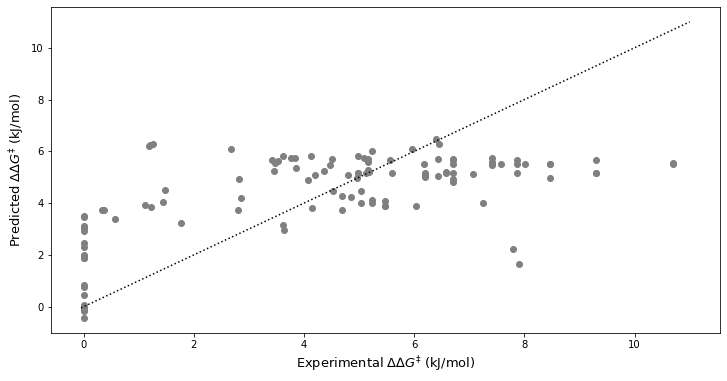


-----
Analyzing predictions for model KNeighborsRegressor
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.5881502380730275, MAE: 1.2960066989313723, MSE: 3.3432512872574964,R2: 0.5862923778030549
-----


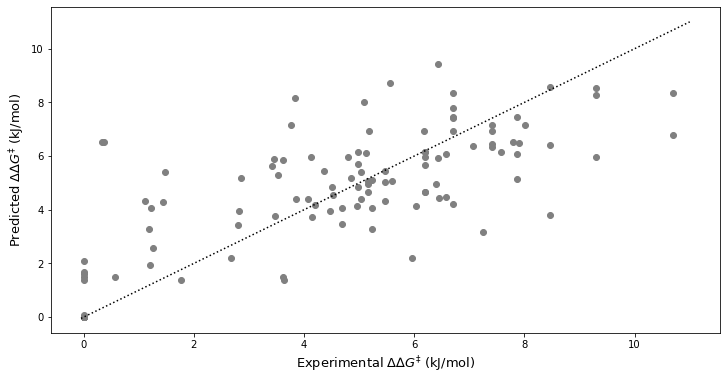


-----
Analyzing predictions for model DecisionTreeRegressor
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: 0.5934401870028049, MAE: 1.3422254253260253, MSE: 3.2885410257522274,R2: 0.5930624498833037
-----


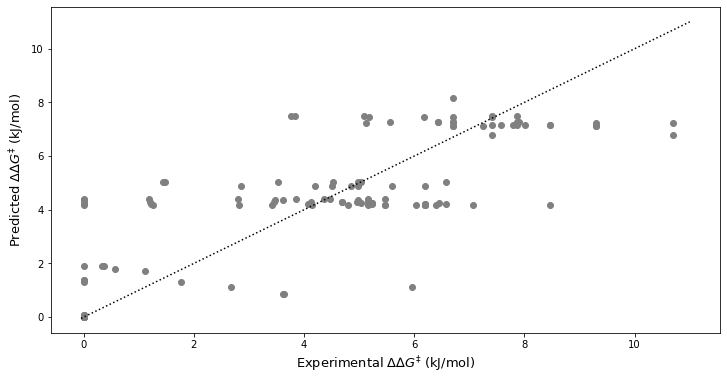


-----
Analyzing predictions for model BayesianRegr
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: -0.018253047018433888, MAE: 2.3799945686293755, MSE: 8.228699831105002,R2: -0.01825305620129347
-----


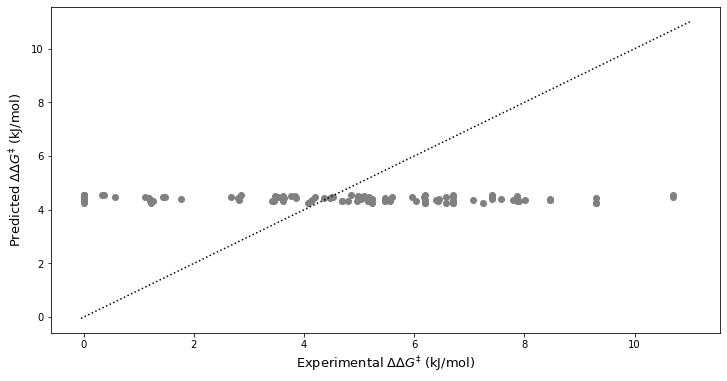


-----
Analyzing predictions for model GaussianProcessRegressor
-----
Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv

-----
 Scores for Regressor: Explained Variance: -6070.989623646301, MAE: 35.62221860596978, MSE: 49595.25211299459,R2: -6136.119845620723
-----


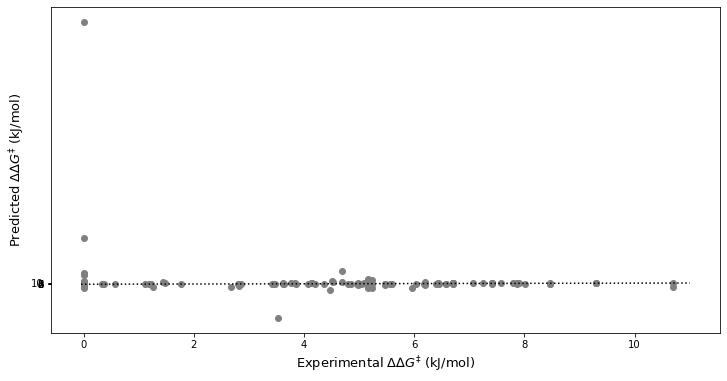

In [18]:
cwf.metrics_for_regression(directories=directory_names)

# Now first we split 90%-10% (train-test)


In [19]:
data = pd.read_csv("DFTdata.csv", header = None)

In [32]:
test_reactions = [44, 33, 69, 0, 6, 35, 56, 67, 58]

In [33]:
train_data = data.drop(labels =test_reactions, axis=0,inplace = False)

In [34]:
test_data = pd.DataFrame()
test_data = data.iloc[test_reactions]

In [36]:
ddg = pd.read_csv("DDG.csv", header = None)

In [37]:
ddg_train = ddg.drop(labels =test_reactions, axis=0,inplace = False)

In [38]:
ddg_test = ddg.iloc[test_reactions]

# Define Xtrain, Xtest, Ytrain, Ytest


In [39]:
Xtrain = train_data
Xtest = test_data
Ytrain = ddg_train
Ytest = ddg_test

# Time for ML


In [40]:
# Possible source:    https://www.kaggle.com/ankitjha/comparing-regression-models
kfold_reg_names = ["LassoCV","KNeighborsRegressor", "DecisionTreeRegressor", 
                   "BayesianRegr", "GaussianProcessRegressor"]
kfold_regressors = [
    LassoCV(random_state=random_seed, cv=10,selection='random',normalize=True,max_iter=1000000),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=random_seed),
#     svm.SVR(),
    linear_model.BayesianRidge(n_iter=100000,normalize=True),
    GaussianProcessRegressor()]

kernel = DotProduct() + WhiteKernel()
kfold_regressors_parameters = {
    "LassoCV":{},
    "KNeighborsRegressor": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "DecisionTreeRegressor": {"max_depth": [2, 3, 4, 5, 7, 10]},
#     "SVR": {"kernel":['linear', 'poly', 'rbf'], "degree":[2,3], "gamma":['auto','scale'], "coef0":[0,1], 'C':[100]},    
    "BayesianRegr":{'alpha_1':[1e-06, 10], 'alpha_2': [1e-06,10],'lambda_1':[1e-06,10], 'lambda_2': [1e-06,10]},
    "GaussianProcessRegressor": {},  
}

In [41]:
%%capture
cwf.split_test_regressors_with_optimization(Xtrain,Ytrain,Xtest,Ytest, kfold_regressors, kfold_regressors_parameters, scale=True, cv=5, n_repeats=10, rgs_names=kfold_reg_names)

Starting regression

-----
Begin LassoCV
-----

Directory LassoCV already exists will be overwritten
	Best parameters; {}
	-0.8615 (+/-1.2984) for {}

	 The predictions are: [4.28559773 4.41358367 6.78926355 1.16136672 5.49183034 4.30368485
 4.60927909 6.37748934 3.62675681]
{'name': 'LassoCV', 'variance': 0.73, 'MAE': 0.99, 'MSE': 1.39, 'RMSE': 1.1789826122551597, 'R2': 0.72}

-----
Begin KNeighborsRegressor
-----

Directory KNeighborsRegressor already exists will be overwritten
	Best parameters; {}
	-1.1811 (+/-1.7507) for {}

	 The predictions are: [[4.37881285]
 [4.39280451]
 [6.08439161]
 [1.8011939 ]
 [5.02008687]
 [3.96003179]
 [5.02008687]
 [6.08439161]
 [3.67252142]]
{'name': 'KNeighborsRegressor', 'variance': 0.63, 'MAE': 1.2, 'MSE': 1.83, 'RMSE': 1.3527749258468684, 'R2': 0.63}

-----
Begin DecisionTreeRegressor
-----

	Best parameters; {}
	-1.8538 (+/-2.4048) for {}

	 The predictions are: [4.68529743 4.68529743 7.90071929 2.41488154 3.47925336 4.68529743
 3.47925336 7.2558